In [1]:
import numpy as np
import cv2
import time
import math
from skimage.measure import label
import matplotlib.pyplot as plt
import torch


class UnetWeight():
    """
    本类实现了Unet的权重计算方法：即：
    W(x) = Wc(x) + W0 * exp(- (d1 + d2)^2 / 2 * sigma^2)
    其中d1,d2分别为像素点到最近组织和次近组织的距离
    为使结果更加明显，本方法权重默认前景为1，背景为 2 + 自适应权重，如有需要，请改变代码weight计算公式即可
    引用自：Ronneberger O, Fischer P, Brox T. U-net: Convolutional networks for biomedical image segmentation[C]
    //International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015: 234-241.
    """
    def __init__(self, w0=10, sigma=5, gpu_device="cuda:0", verbose=False):
        '''
        初始化类
        :param w0: 高斯函数的最大值，论文中采用10
        :param sigma: 高斯函数的sigma，论文中采用5
        :param gpu_device: 基于torch的CUDA加速，选择机器
        :param verbose: 是否展示向屏幕打印信息
        '''
        self._w0 = w0
        self._sigma = sigma
        self._gpu_device = gpu_device
        self._verbose = verbose

    def get_weight(self, mask, method=0, neighbors=4, bg_pixel=0):
        """
        返回根据Unet的方法计算的Weight图
        :param method: 选择什么样的方法，[0,1,2,3]
        :param neighbors: 求label时，4临接或8临接,默认4
        :param bgPixel: 背景像素，针对铝镧枝晶为0
        :return: 返回权重图weight
        """
        weight = None
        if method == 0:
            weight = self._calculate_by_torch(
                mask, neighbors=neighbors, bg_pixel=bg_pixel)
        elif method == 1:
            weight = self._calculate_by_parallel_matrix(
                mask, neighbors=neighbors, bg_pixel=bg_pixel)
        elif method == 2:
            weight = self._calculate_by_contours(
                mask, neighbors=neighbors, bg_pixel=bg_pixel)
        elif method == 3:
            weight = self._calculate_by_point_operation(
                mask, neighbors=neighbors, bg_pixel=bg_pixel)
        return weight

    def _calculate_by_torch(self, mask, neighbors=4, bg_pixel=0):
        '''
        针对真值图 mask 计算U-Net的权重，并返回weight，先计算mask的轮廓坐标，再将mask所有点的坐标与轮廓坐标求欧式距离，
        形成（h,w,n）的三维距离矩阵，h为高，w为宽，n为轮廓点个数，再将上述矩阵按照label的数目求最小，形成（h,w,num_label）,
        num_label为label的数目，按照通道排序后即可得到每个点的d1,d2,即可计算weight
        使用基于torch的GPU加速
        该方法由于要生成（h,w,n）三维矩阵，空间消耗巨大，且随着图像变大指数增长，运行时需考虑图像大小
        :param mask: 真值图，[0,255]，背景为0，前景为255
        :param neighbors:  求label时，4临接或8临接,默认4
        :param bg_pixel: 背景像素，针对铝镧枝晶为0
        :return: 返回权重图weight
        '''
        # ********************************* 为节省时间，每个背景点仅与轮廓点计算欧式距离，即求取轮廓点 *************************
        # 求取轮廓点的坐标 contours_x, contours_y, 和其label_contours
        # contours_x, contours_y, label_contours的shape均为（n,1），n为轮廓点数目，label_contours存取每个轮廓点对应标签
        start_time = time.time()
        # 使用OpenCV2时用这个：
        contours, hierarchy = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         # 使用OpenCV3时用这个：
#         _, contours, hierarchy = cv2.findContours(
#             mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_map = np.zeros(mask.shape)
        cv2.drawContours(contours_map, contours, -1, 1, 1)
        mask_label, num_label = label(
            mask, neighbors=neighbors, background=bg_pixel, return_num=True)
        contours_x, contours_y = np.where(contours_map != 0)
        contours_x = np.array(contours_x)
        contours_y = np.array(contours_y)
        label_contours = np.zeros(contours_x.shape)
        contours_map = contours_map * mask_label  # 为contours_map中每个轮廓点赋值上label的标签
        for index in range(0, len(contours_x)):
            label_contours[index] = contours_map[contours_x[index],
                contours_y[index]]

        end_time = time.time()
        self._print_screen_log(
            "  The duration of contours is {}".format(end_time - start_time))

        # *********** 计算图像中每个点相对于每个轮廓点的欧式距离，即创建（h,w,n）的三维矩阵，n为轮廓点数 *******************
        # 首先分别创建dis_x，dis_y, 然后与轮廓点x,y坐标分别相减求平方，再分别将其扩展到（h,w,n），再开平方
        start_time = time.time()

        h, w = mask.shape[:2]
        contours_x = torch.from_numpy(contours_x).to(self._gpu_device)
        contours_y = torch.from_numpy(contours_y).to(self._gpu_device)
        dis_x = torch.zeros((h, len(contours_x))).to(self._gpu_device)
        dis_y = torch.zeros((w, len(contours_y))).to(self._gpu_device)
        for index in range(h):
            dis_x[index, :] = torch.pow(contours_x - index, 2)
        dis_x = dis_x.unsqueeze(1)
        dis_x = dis_x.repeat(1, w, 1)
        for index in range(w):
            dis_y[index, :] = torch.pow(contours_y - index, 2)
        dis_y = dis_y.unsqueeze(0)
        dis_y = dis_y.repeat(h, 1, 1)
        dis = torch.sqrt(dis_x + dis_y)

        end_time = time.time()
        self._print_screen_log(
            "  The duration of distance is {}".format(end_time - start_time))
        # *********** 计算图像中每个点计算weight *******************
        # 对于dis的每个像素点,求取每个label的最小距离，存成min_dis，并按照通道方向从小到大排序，取最小值和次小值可计算weight
        start_time = time.time()

        min_dis = torch.zeros((h, w, num_label)).to(self._gpu_device)
        label_contours = torch.from_numpy(label_contours).to(self._gpu_device)
        for label_index in range(0, num_label):
            min_dis_label, _ = torch.min(
                dis[:, :, label_contours == (label_index + 1)], 2)
            min_dis[:, :, label_index] = min_dis_label
        min_dis, _ = min_dis.sort(2)
        
        weight = 2 + self._w0 * torch.exp(-1 * (torch.pow(
            (min_dis[:, :, 0] + min_dis[:, :, 1]), 2) / (2 * self._sigma * self._sigma)))
        weight = weight.data.to("cpu").numpy()
        weight[mask == 255] = 1 # 前景点 即晶粒部分设置权重为1

        end_time = time.time()
        self._print_screen_log(
            "  The duration of min is {}".format(end_time - start_time))
        return weight

    def _calculate_by_parallel_matrix(self, mask, neighbors=4, bg_pixel=0):
        '''
        针对真值图 mask 计算U-Net的权重，并返回weight，先计算mask的轮廓坐标，再将mask所有点的坐标与轮廓坐标求欧式距离，
        形成（h,w,n）的三维距离矩阵，h为高，w为宽，n为轮廓点个数，再将上述矩阵按照label的数目求最小，形成（h,w,num_label）,
        num_label为label的数目，按照通道排序后即可得到每个点的d1,d2,即可计算weight
        该方法由于要生成（h,w,n）三维矩阵，空间消耗巨大，且随着图像变大指数增长，运行时需考虑图像大小
        :param mask: 真值图，[0,255]，背景为0，前景为255
        :param neighbors:  求label时，4临接或8临接,默认4
        :param bg_pixel: 背景像素，针对铝镧枝晶为0
        :return: 返回权重图weight
        '''
        # ********************************* 为节省时间，每个背景点仅与轮廓点计算欧式距离，即求取轮廓点 *************************
        # 求取轮廓点的坐标 contours_x, contours_y, 和其label_contours
        # contours_x, contours_y, label_contours的shape均为（n,1），n为轮廓点数目，label_contours存取每个轮廓点对应标签
        start_time = time.time()
        
        # 使用OpenCV2时用这个：
        contours, hierarchy = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         # 使用OpenCV3时用这个：
#         _, contours, hierarchy = cv2.findContours(
#             mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_map = np.zeros(mask.shape)
        cv2.drawContours(contours_map, contours, -1, 1, 1)

        mask_label, num_label = label(mask, neighbors=neighbors, background=bg_pixel, return_num=True)
        contours_map = contours_map * mask_label
        contours_x, contours_y = np.where(contours_map != 0)
        contours_x = np.array(contours_x)
        contours_y = np.array(contours_y)
        label_contours = np.zeros(contours_x.shape)
        for index in range(0, len(contours_x)):  
            label_contours[index] = contours_map[contours_x[index], contours_y[index]]
        
        end_time = time.time()
        self._print_screen_log("  The duration of contours is {}".format(end_time - start_time))

        # *********** 计算图像中每个点相对于每个轮廓点的欧式距离，即创建（h,w,n）的三维矩阵，n为轮廓点数 *******************
        # 首先分别创建dis_x，dis_y, 然后与轮廓点x,y坐标分别相减求平方，再分别将其扩展到（h,w,n），再开平方
        start_time = time.time()
        
        h, w = mask.shape[:2]
        dis_x = np.zeros((h, len(contours_x)))
        dis_y = np.zeros((w, len(contours_y)))

        for index in range(h): 
            temp_dis = np.power(contours_x - index, 2)
            dis_x[index, :] = temp_dis
        dis_x = np.expand_dims(dis_x, axis = 1)
        dis_x = np.repeat(dis_x, w, axis = 1)  

        for index in range(w): 
            temp_dis = np.power(contours_y - index, 2)
            dis_y[index, :] = temp_dis     
        dis_y = np.expand_dims(dis_y, axis = 0)
        dis_y = np.repeat(dis_y, h, axis = 0)

        dis = np.sqrt(dis_x + dis_y)
        
        end_time = time.time()
        self._print_screen_log("  The duration of distance is {}".format(end_time - start_time))
        
#         # 经测试，将dis_x,dis_y首先变成（h,w,n）三维矩阵计算欧式距离，比先算好再复制速度要慢 
#         start_time = time.time()
        
#         h, w = mask.shape[:2]
#         dis_x = np.repeat(np.repeat(np.arange(0, h).reshape(h, 1, 1), w, axis=1), len(contours_x), axis=2)
#         dis_y = np.repeat(np.repeat(np.arange(0, w).reshape(1, w, 1), h, axis=0), len(contours_x), axis=2)
    
#         end_time = time.time()
#         self._print_screen_log("  The duration of dis_x,dis_y is {}".format(end_time - start_time))

#         start_time = time.time()
    
#         dis = np.sqrt(np.power(dis_x - contours_x, 2) + np.power(dis_y - contours_y, 2))
    
#         end_time = time.time()
#         self._print_screen_log("  The duration of distance sqrt is {}".format(end_time - start_time))

        # *********** 计算图像中每个点计算weight *******************
        # 对于dis的每个像素点,求取每个label的最小距离，存成min_dis，并按照通道方向从小到大排序
        start_time = time.time()
        
        weight = np.ones(mask.shape, dtype=np.float32)
        min_dis = np.zeros((h, w, num_label))
        for label_index in range(0, num_label):
            min_dis[:, :, label_index] = np.amin(dis[:,:, label_contours == (label_index + 1)], axis=2)
        min_dis.sort(axis=2)
        weight = 2 + self._w0 * np.exp(-1 * (np.power((min_dis[:, :, 0] + min_dis[:, :, 1]), 2) / (2 * self._sigma * self._sigma)))
        weight[mask == 255] = 1 # 前景点 即晶粒部分设置权重为1
        
        end_time = time.time()
        self._print_screen_log("  The duration of min is {}".format(end_time - start_time))
        return weight
    
    def _calculate_by_contours(self, mask, neighbors=4, bg_pixel = 0):
        '''
        针对真值图 mask 计算U-Net的权重，并返回weight，先计算mask的轮廓坐标，再将mask背景点的坐标与轮廓坐标求欧式距离，
        找到与各个Label的d1,d2求weight
        该方法只去掉一层循环，核心循环没有去掉
        :param mask: 真值图，[0,255]，背景为0，前景为255
        :param neighbors:  求label时，4临接或8临接,默认4
        :param bg_pixel: 背景像素，针对铝镧枝晶为0
        :return: 返回权重图weight
        '''
        weight = np.ones(mask.shape, dtype=np.float32)

        mask_label, num_label = label(mask, neighbors=neighbors, background=bg_pixel, return_num=True)
        # 计算轮廓点，每个轮廓上的值为标签
        # 使用OpenCV2时用这个：
        contours, hierarchy = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         # 使用OpenCV3时用这个：
#         _, contours, hierarchy = cv2.findContours(
#             mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_map = np.zeros(mask_label.shape)
        cv2.drawContours(contours_map, contours, -1, 1, 1)
        contours_map = contours_map * mask_label

        x, y = np.where(contours_map != 0)
        contours = np.ones((len(x), 3))
        contours[:, 1] = contours[:, 1] * x
        contours[:, 2] = contours[:, 2] * y
        for index in range(0, len(x)):  
            point_label = contours_map[x[index], y[index]]
            contours[index, 0] = point_label
        
        # 对每个像素计算Unet的Loss
        for i in range(mask_label.shape[0]):
            for j in range(mask_label.shape[1]):
                if mask_label[i, j] != 0:      # 只判断背景区域的权重，前景区域权重一律为1
                    continue
                d1, d2 = self._find_distances_by_contours(contours, num_label, i, j)
                weight[i, j] = 1 + weight[i, j] + self._w0 * np.exp(-1 * (np.power((d1 + d2), 2) / (2 * self._sigma * self._sigma)))
        return weight
    
    def _find_distances_by_contours(self, contours, num_label, i, j):
        '''
        对于每个背景点，计算d1,d2
        :param countours:ndarry.sahpe = [n,3], 每一行是一个轮廓，第一个元素为轮廓号，第二个和第三个为坐标
        :param num_label:一共多少条轮廓
        :param i:背景点的坐标x
        :param j:背景点的左边y
        :return:d1,d2
        '''
        corr = np.array([i,j])
        dis = np.linalg.norm((contours[:, 1:3] - corr), ord=2, axis=1)  
        min_dis = []
        for label_index in range(1, num_label + 1):
            min_dis.append(np.amin(dis[contours[:, 0] == label_index]))
        min_dis.sort()
        return min_dis[0], min_dis[1]
    
    def _calculate_by_point_operation(self, mask, neighbors=4, bg_pixel=0):
        '''
        针对真值图 mask 计算U-Net的权重，并返回weight，先计算mask的Label，
        再将mask中背景点的坐标与各个Label的坐标求欧式距离，
        找到与各个Label的d1,d2求weight
        该方法为传统方法，速度最慢，但占用空间较小
        :param mask: 真值图，[0,255]，背景为0，前景为255
        :param neighbors:  求label时，4临接或8临接,默认4
        :param bg_pixel: 背景像素，针对铝镧枝晶为0
        :return: 返回权重图weight
        '''
        weight = np.ones(mask.shape, dtype=np.float32)
        mask_label, num_label = label(mask, neighbors=neighbors, 
                                      background=bg_pixel, return_num=True)
        h, w = mask_label.shape[:2]
        for i in range(h):
            for j in range(w):
                if mask_label[i, j] != 0:      # 只判断背景区域的权重，前景区域权重一律为1
                    continue
                d1, d2 = self._find_distances(mask_label, num_label, i, j)
                weight[i, j] = 2 + self._w0 * np.exp(-1 * (np.power((d1 + d2), 2) 
                                                           / (2 * self._sigma * self._sigma)))
        return weight
    
    def _find_distances(self, mask_label, num_label, i, j):
        '''
        对于每个背景点，计算d1,d2
        :param mask_label: mask 的 Label 图
        :param num_label: mask 的 Label 数目
        :param i:背景点的坐标x
        :param j:背景点的左边y
        :return:d1,d2: 本点距离各个晶粒的最小和次小距离
        '''
        d1 = 99999.0
        d2 = 100000.0
        for label_index in range(1, num_label + 1):
            # 返回 mask_label 中为label_index的坐标，x,y 分别为array
            x, y = np.where(mask_label == label_index)
            # 返回 mask_label 中为label_index离该点的坐标
            dis = np.linalg.norm(np.array([i, j] - np.array([x, y]).transpose()), 
                                 ord=2, axis=1)
            min_dis = np.amin(dis)
            if min_dis <= d1:
                d2 = d1
                d1 = min_dis
            elif d1 < min_dis < d2:
                d2 = min_dis
        return d1, d2  
    
    def _print_screen_log(self, content):
        """
        像屏幕打印文字，若self._verbose为真，则可打印
        :param content: 打印内容
        """
        if self._verbose:
            print(content)       
            

if __name__ == '__main__':
    mask = cv2.imread("256_256_mask.png", 0)
    unet_weight= UnetWeight(w0 = 10, sigma = 5, gpu_device = "cuda:0", verbose = True)
    
    print("0. Unet weitght By torch gpu")
    start_time = time.time()

    weight = unet_weight.get_weight(mask, method = 0)
    
    end_time = time.time()
    print("Total Duration is {}".format(end_time-start_time))
    np.save("weight_0.npy",weight)
    
    print("1. Unet weitght By parallel_matrix")
    start_time = time.time()

    weight = unet_weight.get_weight(mask, method = 1)
    
    end_time = time.time()
    print("Total Duration is {}".format(end_time - start_time))
    np.save("weight_1.npy",weight)
    
    print("2. Unet weitght By contours")
    start_time = time.time()

    weight = unet_weight.get_weight(mask, method = 2)
    
    end_time = time.time()
    print("Total Duration is {}".format(end_time - start_time))
    np.save("weight_2.npy",weight)
    
    print("3. Unet weitght By point_operation")
    start_time = time.time()
    
    weight = unet_weight.get_weight(mask, method = 3)
    
    end_time = time.time()
    print("Total Duration is {}".format(end_time - start_time))
    np.save("weight_3.npy",weight)

0. Unet weitght By torch gpu
  The duration of contours is 0.004732370376586914
  The duration of distance is 4.38780951499939
  The duration of min is 0.03290247917175293
Total Duration is 4.426104307174683
1. Unet weitght By parallel_matrix
  The duration of contours is 0.0039865970611572266
  The duration of distance is 3.3117804527282715
  The duration of min is 4.015276908874512
Total Duration is 7.546071529388428
2. Unet weitght By contours
Total Duration is 21.118497848510742
3. Unet weitght By point_operation
Total Duration is 238.64166593551636


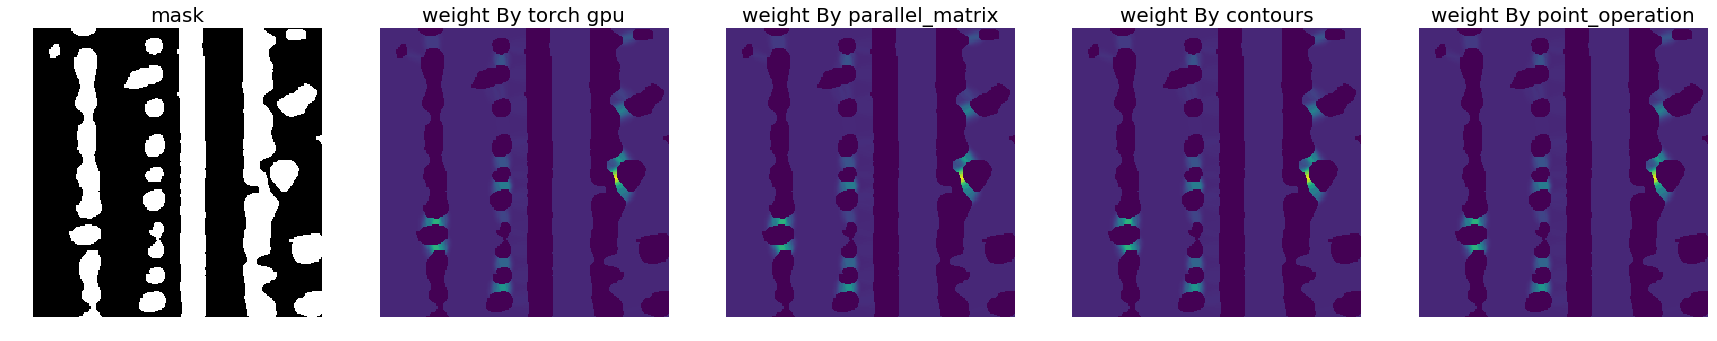

经验证，上述4种方法计算结果相同，结果正确


In [2]:
weight_0 = np.load("weight_0.npy")
weight_1 = np.load("weight_1.npy")
weight_2 = np.load("weight_2.npy")
weight_3 = np.load("weight_3.npy")
plt.figure(figsize=(30,30))
plt.subplot(151)
plt.imshow(mask, cmap="gray")
plt.axis('off')
plt.title("mask", fontsize=20)
plt.subplot(152)
plt.imshow(weight_0)
plt.title("weight By torch gpu", fontsize=20)
plt.axis('off')
plt.subplot(153)
plt.imshow(weight_1)
plt.title("weight By parallel_matrix", fontsize=20)
plt.axis('off')
plt.subplot(154)
plt.imshow(weight_2)
plt.title("weight By contours", fontsize=20)
plt.axis('off')
plt.subplot(155)
plt.imshow(weight_3)
plt.title("weight By point_operation", fontsize=20)
plt.axis('off')
plt.show()

if np.sum(weight_0 - weight_1 - weight_2 - weight_3) < 1:
    print("经验证，上述4种方法计算结果相同，结果正确")
else:
    print("经验证，上述4种方法计算结果不同，结果错误，请排查")